In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker
sns.set_theme(font="Arial", font_scale=1.15, style='ticks') 
matplotlib.rcParams['figure.dpi'] = 150
plt.rc("axes.spines", top=True, right=True)

def perform_fisher_test(row):
    contingency_table = [
        [row['FIRE_COLO829'], row['COV_COLO829'] - row['FIRE_COLO829']],
        [row['FIRE_COLO829BL'], row['COV_COLO829BL'] - row['FIRE_COLO829BL']]
    ]
    oddsratio, p_value = stats.fisher_exact(contingency_table)
    return pd.Series([oddsratio, p_value])

In [4]:
dir1="/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/Improving_SomaticVariantCalling_through_DSA/Fiber-seq/VariantCalls_DeepVariant_1.6.1/FIREs/01.DSA"
colotb = pd.read_table(f"{dir1}/CROSSTAB-FIRE_COLO829T_PassageB_DSA_on_FIRE_merged_COLO829BL_and_TB.FlaggerHap.tsv", sep='\t')
colobl = pd.read_table(f"{dir1}/CROSSTAB-FIRE_COLO829BL_DSA_on_FIRE_merged_COLO829BL_and_TB.FlaggerHap.tsv", sep='\t')

merged_df = pd.merge(colobl[['ID', 'FIRE', 'COV']], colotb[['ID', 'FIRE', 'COV']], on='ID', suffixes=('_COLO829BL', '_COLO829'))
print(merged_df.shape[0])

fireid_overlapped_w_snvs = set(map(lambda x: x.strip(), open(f"{dir1}/Intersect_FIRE-FlaggerHap_with_COLO829T_PassageB_SNVs_Shared_FIREid", 'r').readlines())) 
fireid_overlapped_w_snvs = {x.split('\t')[1] for x in fireid_overlapped_w_snvs}

merged_df_testset = merged_df[(merged_df['COV_COLO829BL'] >= 10) & (merged_df['COV_COLO829BL'] <= 300) & (merged_df['COV_COLO829'] >= 10)]

tqdm.pandas()
merged_df_testset = merged_df_testset.reset_index(drop=True).copy()
#merged_df_testset[['oddsratio', 'pvalue']] = merged_df_testset.progress_apply(perform_fisher_test, axis=1)

247371


In [5]:
merged_df_testset

,ID,FIRE_COLO829BL,COV_COLO829BL,FIRE_COLO829,COV_COLO829
0,haplotype1-0000001:15288-15424,37,155,18,59
1,haplotype1-0000001:15513-15688,121,156,47,60
2,haplotype1-0000001:100858-101044,73,167,63,100
3,haplotype1-0000001:133568-133732,4,179,26,110
4,haplotype1-0000001:170904-171177,8,178,61,131
...,...,...,...,...,...
214405,haplotype2-0000079:171766618-171766783,10,153,23,52
214406,haplotype2-0000079:171794024-171794239,1,102,9,32
214407,haplotype2-0000079:171796662-171797220,12,96,10,29
214408,haplotype2-0000079:171801101-171801258,7,112,8,32


In [6]:
colobl_hap1 = colobl[colobl['ID'].str.startswith('haplotype1-')].copy()
colobl_hap2 = colobl[colobl['ID'].str.startswith('haplotype2-')].copy()
colotb_hap1 = colotb[colotb['ID'].str.startswith('haplotype1-')].copy()
colotb_hap2 = colotb[colotb['ID'].str.startswith('haplotype2-')].copy()

merged_df_hap1 = pd.merge(colobl_hap1[['ID', 'FIRE', 'COV']], colotb_hap1[['ID', 'FIRE', 'COV']], on='ID', suffixes=('_COLO829BL', '_COLO829'))
merged_df_hap2 = pd.merge(colobl_hap2[['ID', 'FIRE', 'COV']], colotb_hap2[['ID', 'FIRE', 'COV']], on='ID', suffixes=('_COLO829BL', '_COLO829'))

#merged_df_hap1['ID'].apply(lambda x: dict(zip(colobl_hap1['ID'], colobl_hap1['FIREid']))[x]) #this will create dictionary with every row in the dataframe => inefficient
id_fireid_dict_hap1 = dict(zip(colobl_hap1['ID'], colobl_hap1['FIREid']))
merged_df_hap1['FIREid'] = merged_df_hap1['ID'].map(id_fireid_dict_hap1)

id_fireid_dict_hap2 = dict(zip(colobl_hap2['ID'], colobl_hap2['FIREid']))
merged_df_hap2['FIREid'] = merged_df_hap2['ID'].map(id_fireid_dict_hap2)

In [7]:
dir2="/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/Improving_SomaticVariantCalling_through_DSA/Fiber-seq/VariantCalls_DeepVariant_1.6.1/FIREs/01.DSA/Haplotypes/FIREs/DSA_Haplotype_FIREs"
# DSA-FIREs Haplotype1 liftOver to Haplotype2
colobl_hap1_to_hap2 = pd.read_table(f"{dir2}/CROSSTAB-FIRE_COLO829BL_DSA_on_FIRE_merged_COLO829BL_and_TB.FlaggerHap_hap1_tohap2.tsv", sep='\t')
colotb_hap1_to_hap2 = pd.read_table(f"{dir2}/CROSSTAB-FIRE_COLO829T_PassageB_DSA_on_FIRE_merged_COLO829BL_and_TB.FlaggerHap_hap1_tohap2.tsv", sep='\t')

merged_df_hap1_to_hap2 = pd.merge(colobl_hap1_to_hap2[['ID', 'FIRE', 'COV']], colotb_hap1_to_hap2[['ID', 'FIRE', 'COV']], on='ID', suffixes=('_COLO829BL_hap1_to_hap2', '_COLO829_hap1_to_hap2'))
  
## DSA-FIREs Haplotype2 liftOver to Haplotype1
colobl_hap2_to_hap1 = pd.read_table(f"{dir2}/CROSSTAB-FIRE_COLO829BL_DSA_on_FIRE_merged_COLO829BL_and_TB.FlaggerHap_hap2_tohap1.tsv", sep='\t')
colotb_hap2_to_hap1 = pd.read_table(f"{dir2}/CROSSTAB-FIRE_COLO829T_PassageB_DSA_on_FIRE_merged_COLO829BL_and_TB.FlaggerHap_hap2_tohap1.tsv", sep='\t')

merged_df_hap2_to_hap1 = pd.merge(colobl_hap2_to_hap1[['ID', 'FIRE', 'COV']], colotb_hap2_to_hap1[['ID', 'FIRE', 'COV']], on='ID', suffixes=('_COLO829BL_hap2_to_hap1', '_COLO829_hap2_to_hap1'))

In [8]:
id_fireid_dict_hap1_to_hap2 = dict(zip(colobl_hap1_to_hap2['ID'], colobl_hap1_to_hap2['FIREid']))
merged_df_hap1_to_hap2['FIREid'] = merged_df_hap1_to_hap2['ID'].map(id_fireid_dict_hap1_to_hap2)

id_fireid_dict_hap2_to_hap1 = dict(zip(colobl_hap2_to_hap1['ID'], colobl_hap2_to_hap1['FIREid']))
merged_df_hap2_to_hap1['FIREid'] = merged_df_hap2_to_hap1['ID'].map(id_fireid_dict_hap2_to_hap1)

In [9]:
id_fireid_dict_hap1_to_hap2_reverse = {v: k for k,v in id_fireid_dict_hap1_to_hap2.items()}
id_fireid_dict_hap2_to_hap1_reverse = {v: k for k,v in id_fireid_dict_hap2_to_hap1.items()}

merged_df_hap1_and_hap1_to_hap2 = pd.merge(merged_df_hap1[['FIREid', 'FIRE_COLO829BL','COV_COLO829BL','FIRE_COLO829','COV_COLO829']], merged_df_hap1_to_hap2[['FIREid', 'FIRE_COLO829BL_hap1_to_hap2', 'COV_COLO829BL_hap1_to_hap2', 'FIRE_COLO829_hap1_to_hap2', 'COV_COLO829_hap1_to_hap2']], on='FIREid')

merged_df_hap1_and_hap1_to_hap2['ID'] = merged_df_hap1_and_hap1_to_hap2['FIREid'].map(id_fireid_dict_hap1_to_hap2_reverse)

merged_df_hap2_and_hap2_to_hap1 = pd.merge(merged_df_hap2[['FIREid', 'FIRE_COLO829BL','COV_COLO829BL','FIRE_COLO829','COV_COLO829']], merged_df_hap2_to_hap1[['FIREid', 'FIRE_COLO829BL_hap2_to_hap1', 'COV_COLO829BL_hap2_to_hap1', 'FIRE_COLO829_hap2_to_hap1', 'COV_COLO829_hap2_to_hap1']], on='FIREid')

merged_df_hap2_and_hap2_to_hap1['ID'] = merged_df_hap2_and_hap2_to_hap1['FIREid'].map(id_fireid_dict_hap2_to_hap1_reverse)

In [10]:
merged_df_hap1_and_hap1_to_hap2_colo829t = merged_df_hap1_and_hap1_to_hap2[['FIREid', 'FIRE_COLO829', 'COV_COLO829', 'FIRE_COLO829_hap1_to_hap2', 'COV_COLO829_hap1_to_hap2', 'ID']]

merged_df_hap1_and_hap1_to_hap2_colo829t_testset = merged_df_hap1_and_hap1_to_hap2_colo829t[(merged_df_hap1_and_hap1_to_hap2_colo829t['COV_COLO829'] >= 10) & (merged_df_hap1_and_hap1_to_hap2_colo829t['COV_COLO829'] <= 300) & (merged_df_hap1_and_hap1_to_hap2_colo829t['COV_COLO829_hap1_to_hap2'] >= 10) & (merged_df_hap1_and_hap1_to_hap2_colo829t['COV_COLO829_hap1_to_hap2'] <= 300)]
merged_df_hap1_and_hap1_to_hap2_colo829t_testset = merged_df_hap1_and_hap1_to_hap2_colo829t_testset.copy()
merged_df_hap1_and_hap1_to_hap2_colo829t_testset['Chromatin-Actuation_COLO829T_hap1'] = merged_df_hap1_and_hap1_to_hap2_colo829t_testset['FIRE_COLO829']*100 /  merged_df_hap1_and_hap1_to_hap2_colo829t_testset['COV_COLO829']
merged_df_hap1_and_hap1_to_hap2_colo829t_testset['Chromatin-Actuation_COLO829T_hap1_to_hap2'] = merged_df_hap1_and_hap1_to_hap2_colo829t_testset['FIRE_COLO829_hap1_to_hap2']*100 /  merged_df_hap1_and_hap1_to_hap2_colo829t_testset['COV_COLO829_hap1_to_hap2']
merged_df_hap1_and_hap1_to_hap2_colo829t_testset['ΔActuation_hap1-hap2'] = merged_df_hap1_and_hap1_to_hap2_colo829t_testset['Chromatin-Actuation_COLO829T_hap1'] - merged_df_hap1_and_hap1_to_hap2_colo829t_testset['Chromatin-Actuation_COLO829T_hap1_to_hap2']
merged_df_hap1_and_hap1_to_hap2_colo829t_testset['SNV_overlap'] = merged_df_hap1_and_hap1_to_hap2_colo829t_testset['FIREid'].isin(fireid_overlapped_w_snvs)

merged_df_hap1_and_hap1_to_hap2_colo829t_testset
#merged_df_testset['SNV_overlap'] = merged_df_testset['ID'].isin(fireid_overlapped_w_snvs)

,FIREid,FIRE_COLO829,COV_COLO829,FIRE_COLO829_hap1_to_hap2,COV_COLO829_hap1_to_hap2,ID,Chromatin-Actuation_COLO829T_hap1,Chromatin-Actuation_COLO829T_hap1_to_hap2,ΔActuation_hap1-hap2,SNV_overlap
0,peak_h1.1,18,59,19,81,haplotype2-0000049:24898483-24898619,30.508475,23.456790,7.051684,False
1,peak_h1.2,47,60,60,83,haplotype2-0000049:24898219-24898394,78.333333,72.289157,6.044177,False
2,peak_h1.3,63,100,74,112,haplotype2-0000049:24810689-24810875,63.000000,66.071429,-3.071429,False
3,peak_h1.4,26,110,21,114,haplotype2-0000049:24778001-24778165,23.636364,18.421053,5.215311,False
4,peak_h1.5,61,131,43,98,haplotype2-0000049:24740564-24740838,46.564885,43.877551,2.687334,False
...,...,...,...,...,...,...,...,...,...,...
121270,peak_h1.127868,45,194,13,46,haplotype2-0000074:36071402-36071701,23.195876,28.260870,-5.064993,False
121271,peak_h1.127869,84,196,22,41,haplotype2-0000074:36075662-36075843,42.857143,53.658537,-10.801394,False
121272,peak_h1.127870,61,178,14,39,haplotype2-0000074:36081068-36081236,34.269663,35.897436,-1.627773,False
121275,peak_h1.127873,12,45,19,59,haplotype2-0000074:36235417-36235570,26.666667,32.203390,-5.536723,False


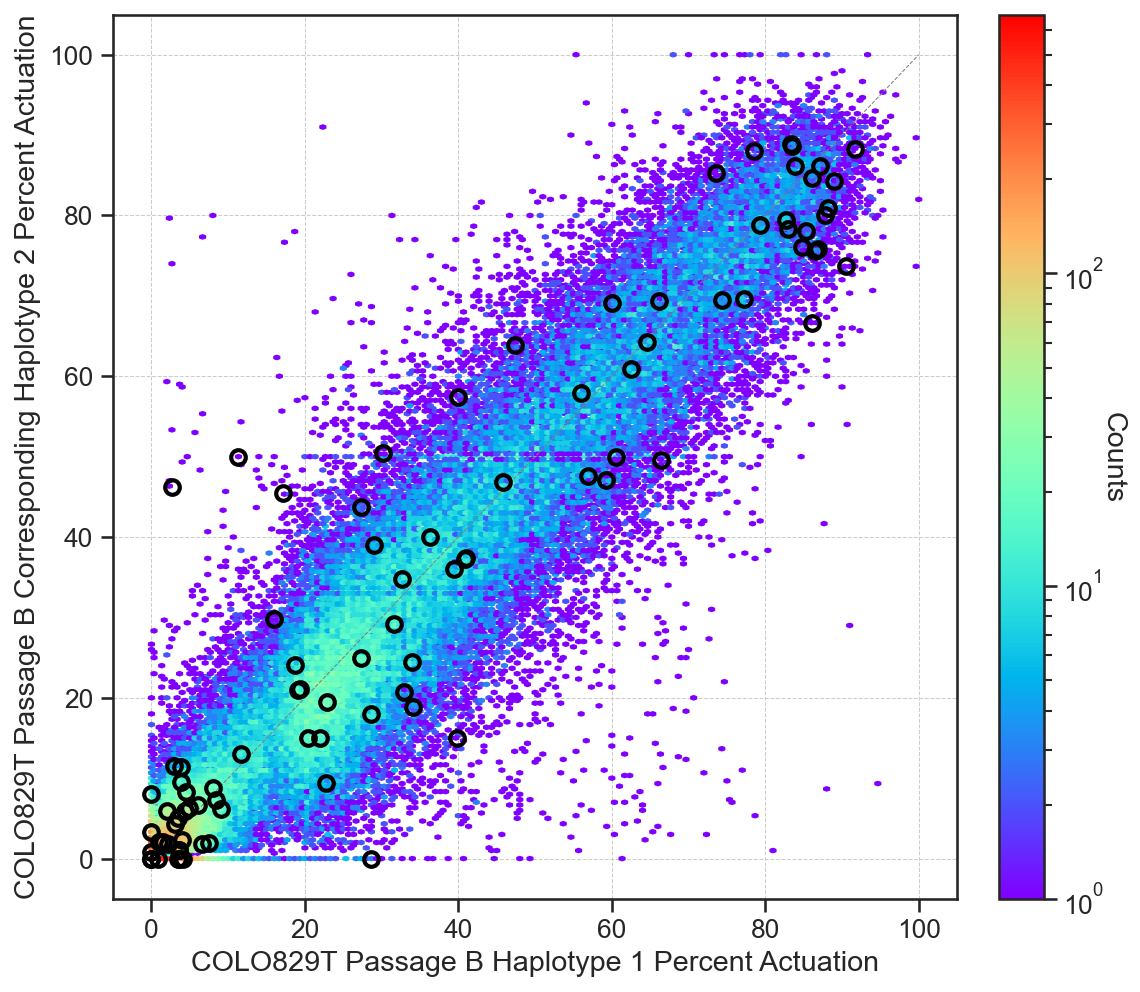

In [11]:
fig, ax = plt.subplots(1,1, figsize=(7.5,6.5), constrained_layout=True)
hb = ax.hexbin(merged_df_hap1_and_hap1_to_hap2_colo829t_testset['Chromatin-Actuation_COLO829T_hap1'], merged_df_hap1_and_hap1_to_hap2_colo829t_testset['Chromatin-Actuation_COLO829T_hap1_to_hap2'], cmap='rainbow', gridsize=(150,150), bins='log')

ax.set_xlabel("COLO829T Passage B Haplotype 1 Percent Actuation")
ax.set_ylabel("COLO829T Passage B Corresponding Haplotype 2 Percent Actuation")
ax.plot([0, 100], [0, 100], color='grey', linestyle='--', linewidth=0.5, zorder=1)
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
cb = fig.colorbar(hb, ax=ax)
cb.set_label(label='Counts', rotation=270, labelpad=10)

for i, row in merged_df_hap1_and_hap1_to_hap2_colo829t_testset.iterrows():
    if row['SNV_overlap']:
        ax.plot(row['Chromatin-Actuation_COLO829T_hap1'], row['Chromatin-Actuation_COLO829T_hap1_to_hap2'], 'o', markersize=7, markeredgewidth=2, markerfacecolor='none', color='black')

In [12]:
merged_df_hap2_and_hap2_to_hap1_colo829t = merged_df_hap2_and_hap2_to_hap1[['FIREid', 'FIRE_COLO829', 'COV_COLO829', 'FIRE_COLO829_hap2_to_hap1', 'COV_COLO829_hap2_to_hap1', 'ID']]

merged_df_hap2_and_hap2_to_hap1_colo829t_testset = merged_df_hap2_and_hap2_to_hap1_colo829t[(merged_df_hap2_and_hap2_to_hap1_colo829t['COV_COLO829'] >= 10) & (merged_df_hap2_and_hap2_to_hap1_colo829t['COV_COLO829'] <= 300) & (merged_df_hap2_and_hap2_to_hap1_colo829t['COV_COLO829_hap2_to_hap1'] >= 10) & (merged_df_hap2_and_hap2_to_hap1_colo829t['COV_COLO829_hap2_to_hap1'] <= 300)]
merged_df_hap2_and_hap2_to_hap1_colo829t_testset = merged_df_hap2_and_hap2_to_hap1_colo829t_testset.copy()
merged_df_hap2_and_hap2_to_hap1_colo829t_testset['Chromatin-Actuation_COLO829T_hap2'] = merged_df_hap2_and_hap2_to_hap1_colo829t_testset['FIRE_COLO829']*100 /  merged_df_hap2_and_hap2_to_hap1_colo829t_testset['COV_COLO829']
merged_df_hap2_and_hap2_to_hap1_colo829t_testset['Chromatin-Actuation_COLO829T_hap2_to_hap1'] = merged_df_hap2_and_hap2_to_hap1_colo829t_testset['FIRE_COLO829_hap2_to_hap1']*100 /  merged_df_hap2_and_hap2_to_hap1_colo829t_testset['COV_COLO829_hap2_to_hap1']
merged_df_hap2_and_hap2_to_hap1_colo829t_testset['ΔActuation_hap2-hap1'] = merged_df_hap2_and_hap2_to_hap1_colo829t_testset['Chromatin-Actuation_COLO829T_hap2'] - merged_df_hap2_and_hap2_to_hap1_colo829t_testset['Chromatin-Actuation_COLO829T_hap2_to_hap1']
merged_df_hap2_and_hap2_to_hap1_colo829t_testset['SNV_overlap'] = merged_df_hap2_and_hap2_to_hap1_colo829t_testset['FIREid'].isin(fireid_overlapped_w_snvs)

merged_df_hap2_and_hap2_to_hap1_colo829t_testset
#merged_df_testset['SNV_overlap'] = merged_df_testset['ID'].isin(fireid_overlapped_w_snvs)

,FIREid,FIRE_COLO829,COV_COLO829,FIRE_COLO829_hap2_to_hap1,COV_COLO829_hap2_to_hap1,ID,Chromatin-Actuation_COLO829T_hap2,Chromatin-Actuation_COLO829T_hap2_to_hap1,ΔActuation_hap2-hap1,SNV_overlap
0,peak_h2.1,20,96,15,76,haplotype1-0000016:116178-116340,20.833333,19.736842,1.096491,False
1,peak_h2.2,2,79,2,69,haplotype1-0000016:132335-132534,2.531646,2.898551,-0.366905,True
2,peak_h2.3,35,83,31,88,haplotype1-0000016:197555-197728,42.168675,35.227273,6.941402,False
3,peak_h2.4,12,78,13,84,haplotype1-0000016:243625-243790,15.384615,15.476190,-0.091575,False
4,peak_h2.5,37,70,56,92,haplotype1-0000016:247089-247237,52.857143,60.869565,-8.012422,False
...,...,...,...,...,...,...,...,...,...,...
118156,peak_h2.119437,23,48,3,70,haplotype1-0000026:172089080-172089254,47.916667,4.285714,43.630952,False
118157,peak_h2.119438,23,52,23,66,haplotype1-0000026:172123870-172124035,44.230769,34.848485,9.382284,False
118158,peak_h2.119440,10,29,15,53,haplotype1-0000026:172145062-172145620,34.482759,28.301887,6.180872,False
118159,peak_h2.119441,8,32,9,51,haplotype1-0000026:172149475-172149632,25.000000,17.647059,7.352941,False


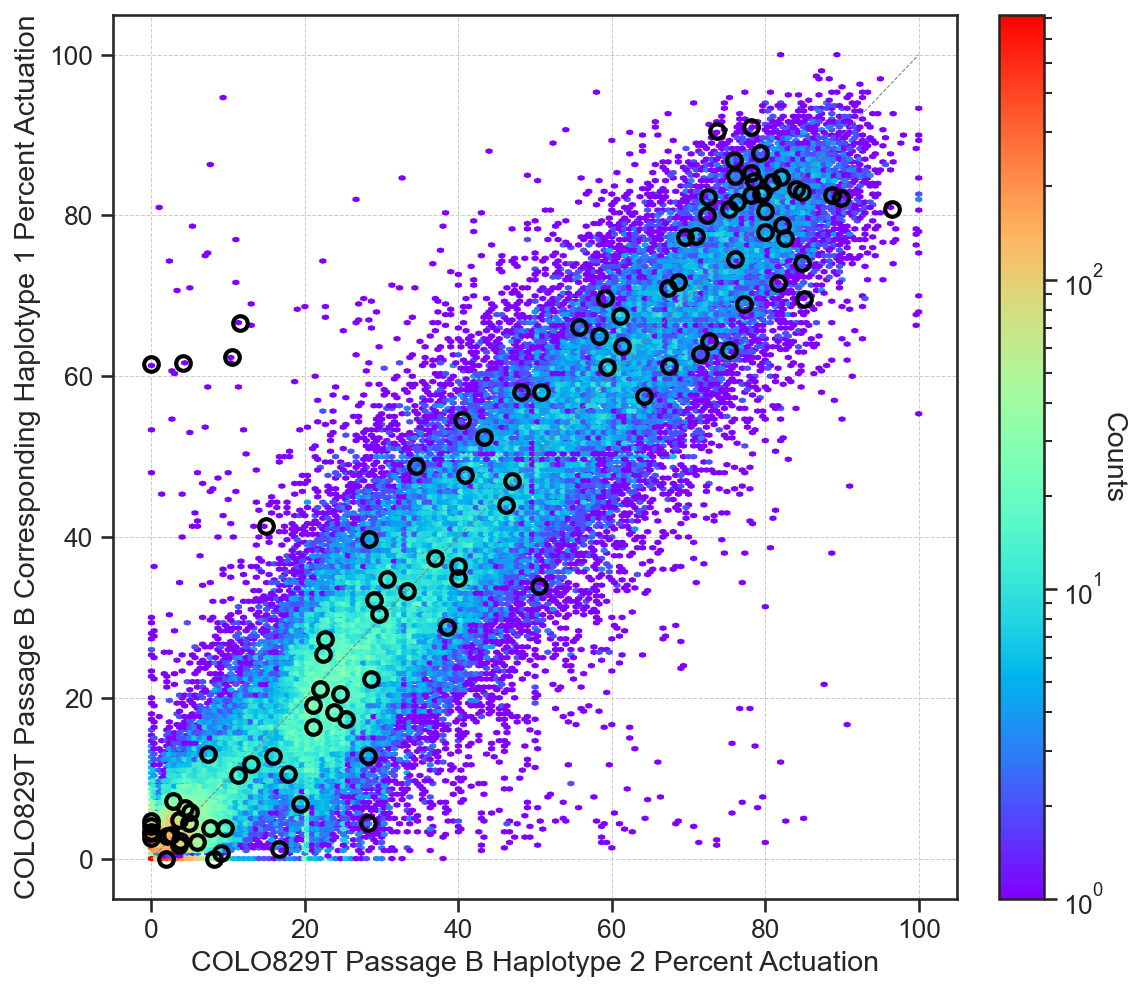

In [13]:
fig, ax = plt.subplots(1,1, figsize=(7.5,6.5), constrained_layout=True)
hb = ax.hexbin(merged_df_hap2_and_hap2_to_hap1_colo829t_testset['Chromatin-Actuation_COLO829T_hap2'], merged_df_hap2_and_hap2_to_hap1_colo829t_testset['Chromatin-Actuation_COLO829T_hap2_to_hap1'], cmap='rainbow', gridsize=(150,150), bins='log')

ax.set_xlabel("COLO829T Passage B Haplotype 2 Percent Actuation")
ax.set_ylabel("COLO829T Passage B Corresponding Haplotype 1 Percent Actuation")
ax.plot([0, 100], [0, 100], color='grey', linestyle='--', linewidth=0.5, zorder=1)
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
cb = fig.colorbar(hb, ax=ax)
cb.set_label(label='Counts', rotation=270, labelpad=10)

for i, row in merged_df_hap2_and_hap2_to_hap1_colo829t_testset.iterrows():
    if row['SNV_overlap']:
        ax.plot(row['Chromatin-Actuation_COLO829T_hap2'], row['Chromatin-Actuation_COLO829T_hap2_to_hap1'], 'o', markersize=7, markeredgewidth=2, markerfacecolor='none', color='black')

In [14]:
merged_df_hap1_and_hap1_to_hap2_testset = merged_df_hap1_and_hap1_to_hap2[(merged_df_hap1_and_hap1_to_hap2['COV_COLO829'] >= 10) & (merged_df_hap1_and_hap1_to_hap2['COV_COLO829'] <= 300) & (merged_df_hap1_and_hap1_to_hap2['COV_COLO829_hap1_to_hap2'] >= 10) & (merged_df_hap1_and_hap1_to_hap2['COV_COLO829_hap1_to_hap2'] <= 300)]

merged_df_hap1_and_hap1_to_hap2_testset = merged_df_hap1_and_hap1_to_hap2_testset.copy()
merged_df_hap1_and_hap1_to_hap2_testset['SNV_overlap'] = merged_df_hap1_and_hap1_to_hap2_testset['FIREid'].isin(fireid_overlapped_w_snvs)
merged_df_hap1_and_hap1_to_hap2_testset['Chromatin-Actuation_COLO829BL_hap1'] = merged_df_hap1_and_hap1_to_hap2_testset['FIRE_COLO829BL']*100 /  merged_df_hap1_and_hap1_to_hap2_testset['COV_COLO829BL']
merged_df_hap1_and_hap1_to_hap2_testset['Chromatin-Actuation_COLO829BL_hap1_to_hap2'] = merged_df_hap1_and_hap1_to_hap2_testset['FIRE_COLO829BL_hap1_to_hap2']*100 / merged_df_hap1_and_hap1_to_hap2_testset['COV_COLO829BL_hap1_to_hap2']
merged_df_hap1_and_hap1_to_hap2_testset['Chromatin-Actuation_COLO829T_hap1'] = merged_df_hap1_and_hap1_to_hap2_testset['FIRE_COLO829']*100 /  merged_df_hap1_and_hap1_to_hap2_testset['COV_COLO829']
merged_df_hap1_and_hap1_to_hap2_testset['Chromatin-Actuation_COLO829T_hap1_to_hap2'] = merged_df_hap1_and_hap1_to_hap2_testset['FIRE_COLO829_hap1_to_hap2']*100 / merged_df_hap1_and_hap1_to_hap2_testset['COV_COLO829_hap1_to_hap2']

merged_df_hap1_and_hap1_to_hap2_testset['ΔActuation_COLO829BL_hap1-hap2'] = merged_df_hap1_and_hap1_to_hap2_testset['Chromatin-Actuation_COLO829BL_hap1'] - merged_df_hap1_and_hap1_to_hap2_testset['Chromatin-Actuation_COLO829BL_hap1_to_hap2']
merged_df_hap1_and_hap1_to_hap2_testset['ΔActuation_COLO829T_hap1-hap2'] = merged_df_hap1_and_hap1_to_hap2_testset['Chromatin-Actuation_COLO829T_hap1'] - merged_df_hap1_and_hap1_to_hap2_testset['Chromatin-Actuation_COLO829T_hap1_to_hap2']

merged_df_hap1_and_hap1_to_hap2_testset['Abs_ΔActuation_COLO829BL_hap1-hap2'] = abs(merged_df_hap1_and_hap1_to_hap2_testset['Chromatin-Actuation_COLO829BL_hap1'] - merged_df_hap1_and_hap1_to_hap2_testset['Chromatin-Actuation_COLO829BL_hap1_to_hap2'])
merged_df_hap1_and_hap1_to_hap2_testset['Abs_ΔActuation_COLO829T_hap1-hap2'] = abs(merged_df_hap1_and_hap1_to_hap2_testset['Chromatin-Actuation_COLO829T_hap1'] - merged_df_hap1_and_hap1_to_hap2_testset['Chromatin-Actuation_COLO829T_hap1_to_hap2'])


merged_df_hap2_and_hap2_to_hap1_testset = merged_df_hap2_and_hap2_to_hap1[(merged_df_hap2_and_hap2_to_hap1['COV_COLO829'] >= 10) & (merged_df_hap2_and_hap2_to_hap1['COV_COLO829'] <= 300) & (merged_df_hap2_and_hap2_to_hap1['COV_COLO829_hap2_to_hap1'] >= 10) & (merged_df_hap2_and_hap2_to_hap1['COV_COLO829_hap2_to_hap1'] <= 300)]

merged_df_hap2_and_hap2_to_hap1_testset = merged_df_hap2_and_hap2_to_hap1_testset.copy()
merged_df_hap2_and_hap2_to_hap1_testset['SNV_overlap'] = merged_df_hap2_and_hap2_to_hap1_testset['FIREid'].isin(fireid_overlapped_w_snvs)
merged_df_hap2_and_hap2_to_hap1_testset['Chromatin-Actuation_COLO829BL_hap2'] = merged_df_hap2_and_hap2_to_hap1_testset['FIRE_COLO829BL']*100 /  merged_df_hap2_and_hap2_to_hap1_testset['COV_COLO829BL']
merged_df_hap2_and_hap2_to_hap1_testset['Chromatin-Actuation_COLO829BL_hap2_to_hap1'] = merged_df_hap2_and_hap2_to_hap1_testset['FIRE_COLO829BL_hap2_to_hap1']*100 / merged_df_hap2_and_hap2_to_hap1_testset['COV_COLO829BL_hap2_to_hap1']
merged_df_hap2_and_hap2_to_hap1_testset['Chromatin-Actuation_COLO829T_hap2'] = merged_df_hap2_and_hap2_to_hap1_testset['FIRE_COLO829']*100 /  merged_df_hap2_and_hap2_to_hap1_testset['COV_COLO829']
merged_df_hap2_and_hap2_to_hap1_testset['Chromatin-Actuation_COLO829T_hap2_to_hap1'] = merged_df_hap2_and_hap2_to_hap1_testset['FIRE_COLO829_hap2_to_hap1']*100 / merged_df_hap2_and_hap2_to_hap1_testset['COV_COLO829_hap2_to_hap1']

merged_df_hap2_and_hap2_to_hap1_testset['ΔActuation_COLO829BL_hap2-hap1'] = merged_df_hap2_and_hap2_to_hap1_testset['Chromatin-Actuation_COLO829BL_hap2'] - merged_df_hap2_and_hap2_to_hap1_testset['Chromatin-Actuation_COLO829BL_hap2_to_hap1']
merged_df_hap2_and_hap2_to_hap1_testset['ΔActuation_COLO829T_hap2-hap1'] = merged_df_hap2_and_hap2_to_hap1_testset['Chromatin-Actuation_COLO829T_hap2'] - merged_df_hap2_and_hap2_to_hap1_testset['Chromatin-Actuation_COLO829T_hap2_to_hap1']

merged_df_hap2_and_hap2_to_hap1_testset['Abs_ΔActuation_COLO829BL_hap2-hap1'] = abs(merged_df_hap2_and_hap2_to_hap1_testset['Chromatin-Actuation_COLO829BL_hap2'] - merged_df_hap2_and_hap2_to_hap1_testset['Chromatin-Actuation_COLO829BL_hap2_to_hap1'])
merged_df_hap2_and_hap2_to_hap1_testset['Abs_ΔActuation_COLO829T_hap2-hap1'] = abs(merged_df_hap2_and_hap2_to_hap1_testset['Chromatin-Actuation_COLO829T_hap2'] - merged_df_hap2_and_hap2_to_hap1_testset['Chromatin-Actuation_COLO829T_hap2_to_hap1'])

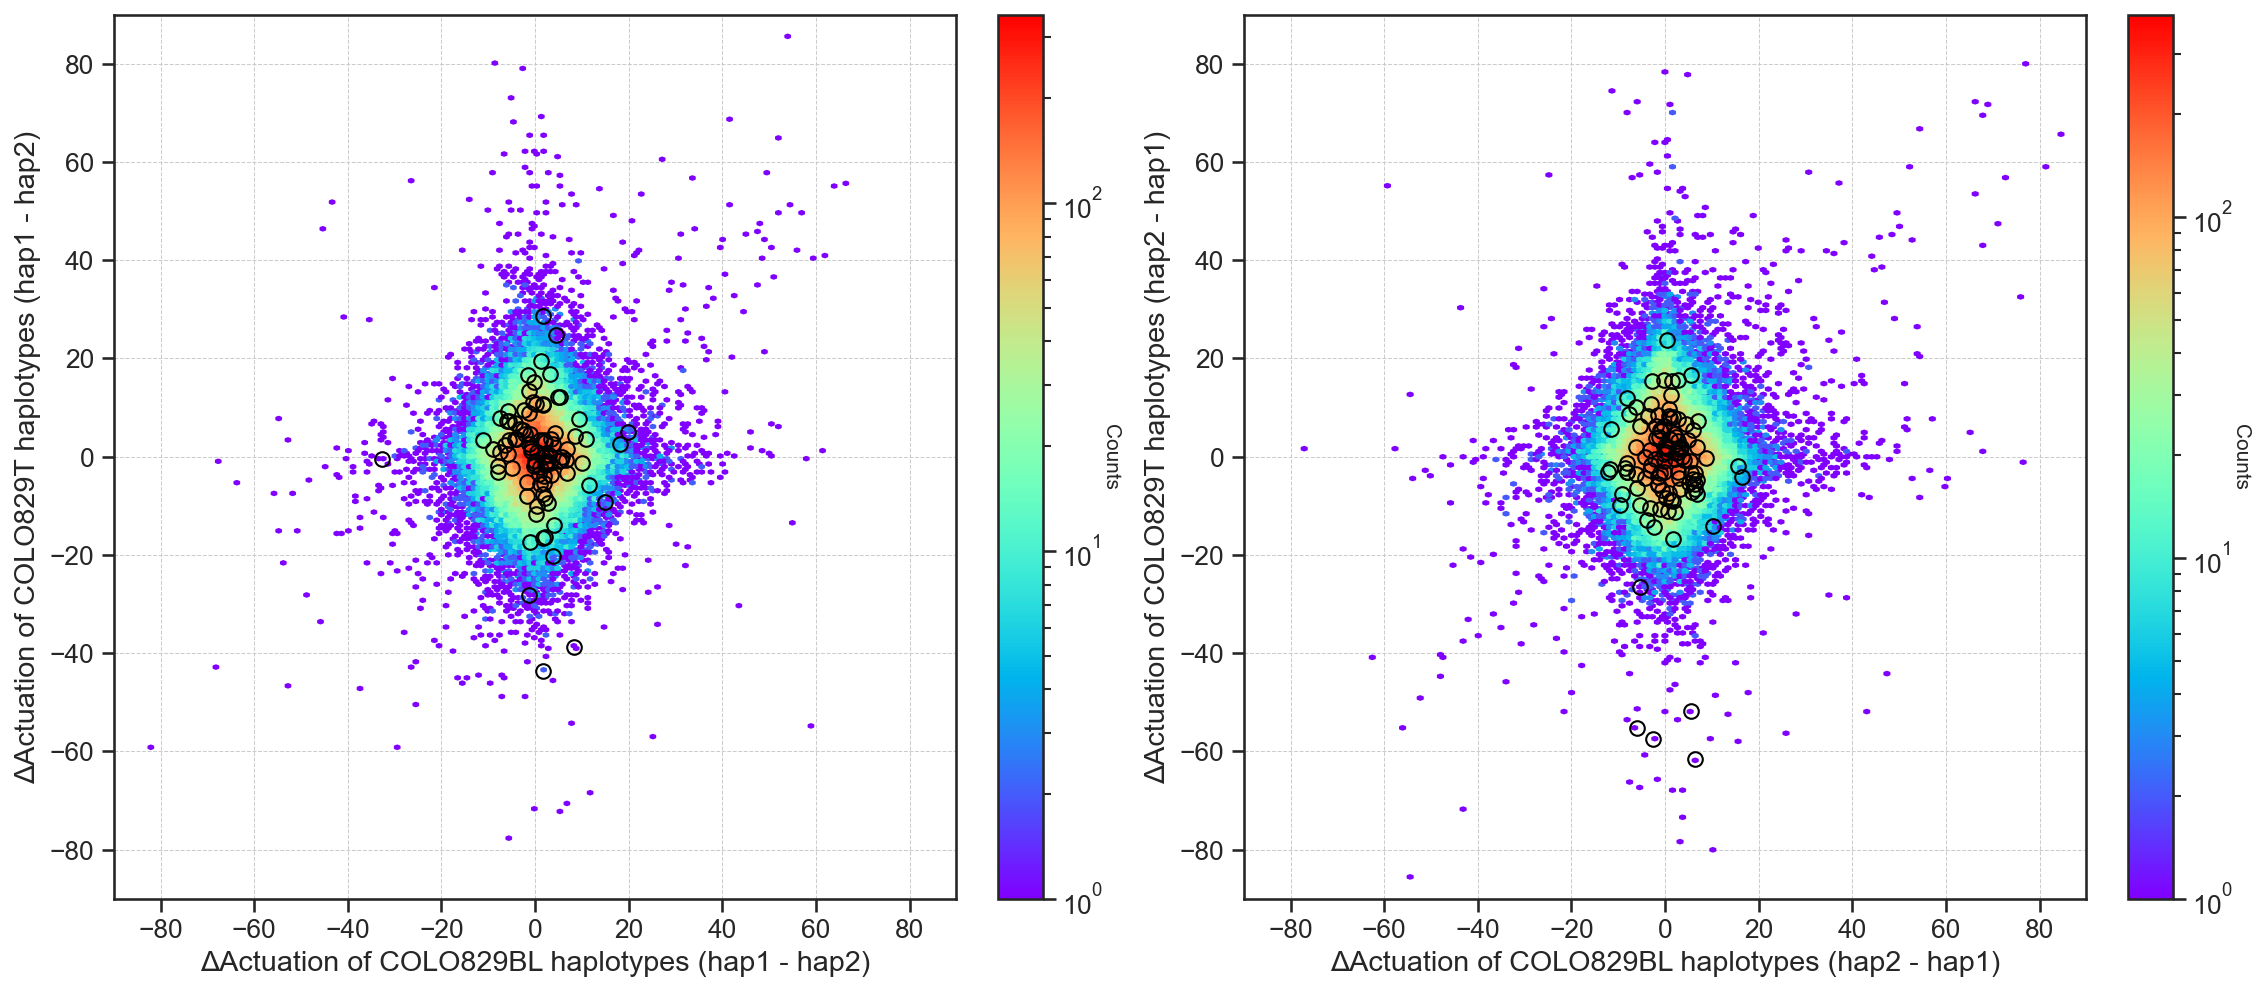

In [15]:
fig, ax = plt.subplots(1,2, figsize=(15, 6.5), constrained_layout=True)

hb1 = ax[0].hexbin(merged_df_hap1_and_hap1_to_hap2_testset['ΔActuation_COLO829BL_hap1-hap2'], merged_df_hap1_and_hap1_to_hap2_testset['ΔActuation_COLO829T_hap1-hap2'], cmap='rainbow', gridsize=(150,150), bins='log')
cb1 = fig.colorbar(hb1, ax=ax[0])
cb1.set_label(label='Counts', rotation=270, labelpad=8, fontsize=10)

ax[0].set_xlim(-90, 90)
ax[0].set_ylim(-90, 90)

ax[0].set_xlabel("ΔActuation of COLO829BL haplotypes (hap1 - hap2)")
ax[0].set_ylabel("ΔActuation of COLO829T haplotypes (hap1 - hap2)")

ax[0].grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

for i, row in merged_df_hap1_and_hap1_to_hap2_testset.iterrows():
    if row['SNV_overlap']:
        ax[0].plot(row['ΔActuation_COLO829BL_hap1-hap2'], row['ΔActuation_COLO829T_hap1-hap2'], 'o', markersize=7, markeredgewidth=1, markerfacecolor='none', color='black')

hb2 = ax[1].hexbin(merged_df_hap2_and_hap2_to_hap1_testset['ΔActuation_COLO829BL_hap2-hap1'], merged_df_hap2_and_hap2_to_hap1_testset['ΔActuation_COLO829T_hap2-hap1'], cmap='rainbow', gridsize=(150,150), bins='log')
cb2 = fig.colorbar(hb2, ax=ax[1])
cb2.set_label(label='Counts', rotation=270, labelpad=8, fontsize=10)

ax[1].set_xlim(-90, 90)
ax[1].set_ylim(-90, 90)

ax[1].set_xlabel("ΔActuation of COLO829BL haplotypes (hap2 - hap1)")
ax[1].set_ylabel("ΔActuation of COLO829T haplotypes (hap2 - hap1)")

ax[1].grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

for i, row in merged_df_hap2_and_hap2_to_hap1_testset.iterrows():
    if row['SNV_overlap']:
        ax[1].plot(row['ΔActuation_COLO829BL_hap2-hap1'], row['ΔActuation_COLO829T_hap2-hap1'], 'o', markersize=7, markeredgewidth=1, markerfacecolor='none', color='black')

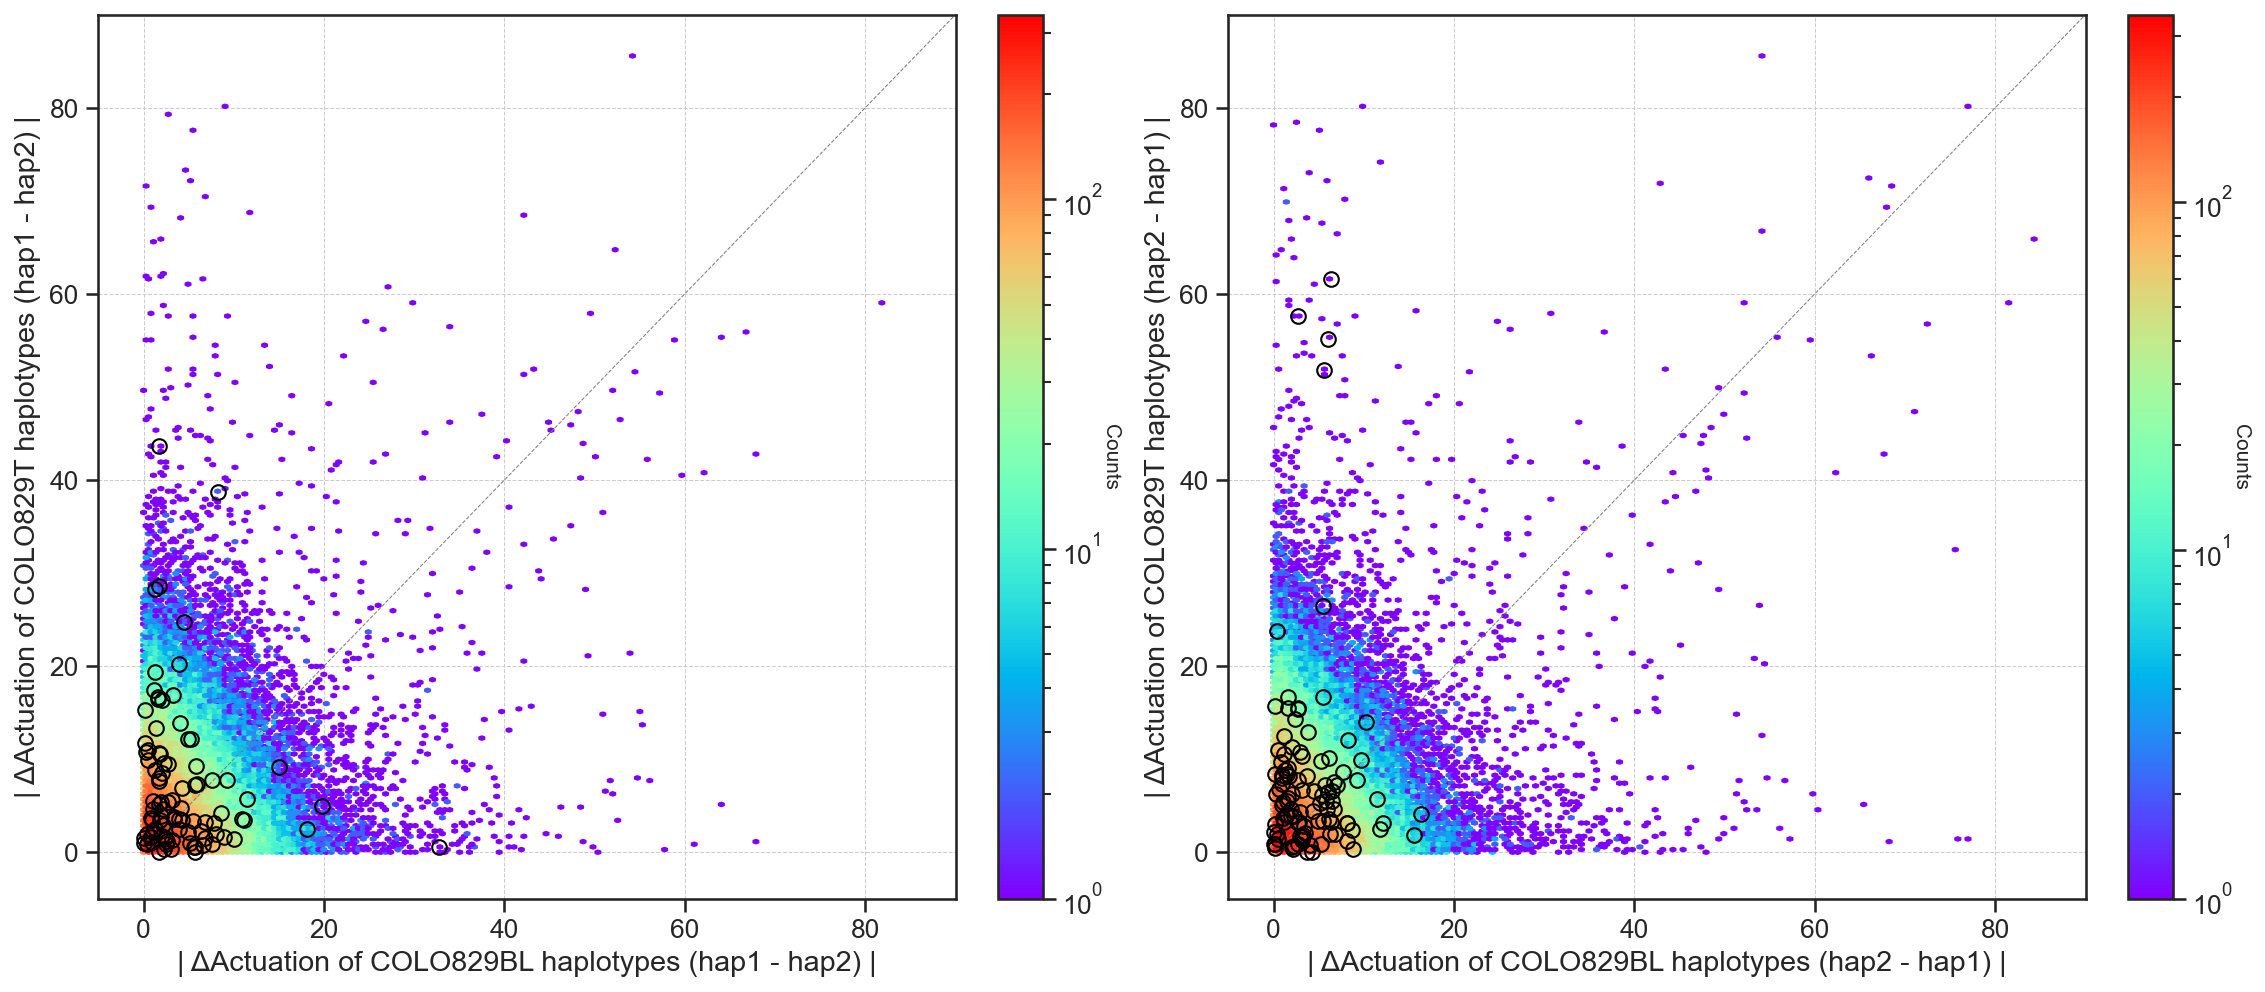

In [16]:
fig, ax = plt.subplots(1,2, figsize=(15, 6.5), constrained_layout=True)

hb1 = ax[0].hexbin(merged_df_hap1_and_hap1_to_hap2_testset['Abs_ΔActuation_COLO829BL_hap1-hap2'], merged_df_hap1_and_hap1_to_hap2_testset['Abs_ΔActuation_COLO829T_hap1-hap2'], cmap='rainbow', gridsize=(150,150), bins='log')
cb1 = fig.colorbar(hb1, ax=ax[0])
cb1.set_label(label='Counts', rotation=270, labelpad=8, fontsize=10)

ax[0].set_xlim(-5, 90)
ax[0].set_ylim(-5, 90)

ax[0].set_xlabel("| ΔActuation of COLO829BL haplotypes (hap1 - hap2) |")
ax[0].set_ylabel("| ΔActuation of COLO829T haplotypes (hap1 - hap2) |")

ax[0].grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
ax[0].plot([0, 100], [0, 100], color='grey', linestyle='--', linewidth=0.5, zorder=1)

for i, row in merged_df_hap1_and_hap1_to_hap2_testset.iterrows():
    if row['SNV_overlap']:
        ax[0].plot(row['Abs_ΔActuation_COLO829BL_hap1-hap2'], row['Abs_ΔActuation_COLO829T_hap1-hap2'], 'o', markersize=7, markeredgewidth=1, markerfacecolor='none', color='black')

hb2 = ax[1].hexbin(merged_df_hap2_and_hap2_to_hap1_testset['Abs_ΔActuation_COLO829BL_hap2-hap1'], merged_df_hap2_and_hap2_to_hap1_testset['Abs_ΔActuation_COLO829T_hap2-hap1'], cmap='rainbow', gridsize=(150,150), bins='log')
cb2 = fig.colorbar(hb2, ax=ax[1])
cb2.set_label(label='Counts', rotation=270, labelpad=8, fontsize=10)

ax[1].set_xlim(-5, 90)
ax[1].set_ylim(-5, 90)

ax[1].set_xlabel("| ΔActuation of COLO829BL haplotypes (hap2 - hap1) |")
ax[1].set_ylabel("| ΔActuation of COLO829T haplotypes (hap2 - hap1) |")

ax[1].grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
ax[1].plot([0, 100], [0, 100], color='grey', linestyle='--', linewidth=0.5, zorder=1)

for i, row in merged_df_hap2_and_hap2_to_hap1_testset.iterrows():
    if row['SNV_overlap']:
        ax[1].plot(row['Abs_ΔActuation_COLO829BL_hap2-hap1'], row['Abs_ΔActuation_COLO829T_hap2-hap1'], 'o', markersize=7, markeredgewidth=1, markerfacecolor='none', color='black')

In [17]:
"""
fireid_overlapped_w_snvs = set(map(lambda x: x.strip(), open(f"{dir1}/Intersect_FIRE-FlaggerHap_with_COLO829T_PassageB_SNVs_Shared_FIREid", 'r').readlines())) 

merged_df_testset = merged_df[(merged_df['COV_COLO829BL'] >= 10) & (merged_df['COV_COLO829BL'] <= 300) & (merged_df['COV_COLO829'] >= 10)]

tqdm.pandas()
merged_df_testset = merged_df_testset.reset_index(drop=True).copy()
merged_df_testset[['oddsratio', 'pvalue']] = merged_df_testset.progress_apply(perform_fisher_test, axis=1)
"""

'\nfireid_overlapped_w_snvs = set(map(lambda x: x.strip(), open(f"{dir1}/Intersect_FIRE-FlaggerHap_with_COLO829T_PassageB_SNVs_Shared_FIREid", \'r\').readlines())) \n\nmerged_df_testset = merged_df[(merged_df[\'COV_COLO829BL\'] >= 10) & (merged_df[\'COV_COLO829BL\'] <= 300) & (merged_df[\'COV_COLO829\'] >= 10)]\n\ntqdm.pandas()\nmerged_df_testset = merged_df_testset.reset_index(drop=True).copy()\nmerged_df_testset[[\'oddsratio\', \'pvalue\']] = merged_df_testset.progress_apply(perform_fisher_test, axis=1)\n'